## 学習 (Step1:Not Human in the loop) の結果確認
Step1として通常の教師あり学習として学習したモデルを評価する．<br>
ここでは，正解率，Attention，Sigmoid Attentionを評価する．

In [1]:
import os
import cv2
import torch
import numpy as np
import torchvision
from tqdm import tqdm

from models.vit import Block
from datetime import datetime
from torchinfo import summary
from torch.nn import LayerNorm

import matplotlib.pyplot as plt
from timm.layers import PatchEmbed, Mlp
from torchvision import datasets, transforms

from models.vit import VisionTransformer
from models.sigmoid_attention import Sigmoid_Attention
from utils import Attention_Rollout, heatmap_to_rgb


# check GPU usage
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
if torch.cuda.device_count()==0: print('Use 1 GPU') 
else: print(f'Use {torch.cuda.device_count()} GPUs')

date = datetime.now().strftime("%Y%m%d_%H%M")
save_dir = f"./result/result{date}"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Use 4 GPUs


### 設定

In [2]:
# Config
model_pth = "./result/run_cub200_FT/best_acc.pt"
dataset_path="/taiga/share/ABN_Fine-tuning/dataset/cub200"
num_classes = 200
dataset = "cub200"

### Modelの読み込み
timmで公開されているモデルは，Attentionの取得ができない．<br>
そこで，local上で改変したモデルを読み込む．このモデルは，重みをそのまま読み込ませることが可能である<br>．
このとき，`model_config`を以下のように設定してモデルを読み込むことで，timmで読み込むものと同じになる．

In [3]:
# vit_small_patch16_224 の設定
model_config = {
    "img_size": (224, 224),
    "patch_size": 16,
    "in_chans": 3,
    "num_classes": num_classes,
    "global_pool": 'token',
    "embed_dim": 384,
    "depth": 12,
    "num_heads": 6,
    "mlp_ratio": 4.0,
    "qkv_bias": True,
    "qk_norm": False,
    "init_values": None,
    "class_token": True,
    "pos_embed": 'learn',
    "no_embed_class": False,
    "reg_tokens": 0,
    "pre_norm": False,
    "fc_norm": None,
    "dynamic_img_size": False,
    "dynamic_img_pad": False,
    "drop_rate": 0.0,
    "pos_drop_rate": 0.0,
    "patch_drop_rate": 0.0,
    "proj_drop_rate": 0.0,
    "attn_drop_rate": 0.0,
    "drop_path_rate": 0.0,
    "weight_init": '',  # 空の文字列に設定
    "fix_init": False,
    "embed_layer": PatchEmbed,
    "norm_layer": LayerNorm,
    "act_layer": None,
    "block_fn": Block,
    "mlp_layer": Mlp,
}

In [4]:
## timm ViTの読み込み
#from timm.models import create_model
#model = create_model("vit_small_patch16_224", pretrained=False, num_classes=num_classes)

## localモデルでの読み込み
model = VisionTransformer(**model_config)
model.blocks[-1].attn = Sigmoid_Attention(dim=model_config['embed_dim'], 
                                          num_heads=model_config['num_heads'], 
                                          qkv_bias=model_config['qkv_bias']
                                          )

state_dict = torch.load(model_pth, map_location=torch.device('cpu'), weights_only=True)

msg = model.load_state_dict(state_dict, strict=False)
print("model.load_state_dict msg : ", msg)

model = model.to(device)

model.load_state_dict msg :  <All keys matched successfully>


### データセットの読み込み

In [5]:
# データセットの用意
if dataset == "cifar10":
    
    transform_test = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
    print(f"dataset : {testset}\nlen(trainset) : {len(testset)}")

    idx_to_class = ['plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    #testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=8)


elif dataset == "cub200":

    transform_test = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize((0.4817, 0.4974, 0.4319), (0.2297, 0.2256, 0.2655)),
    ])

    testset = datasets.ImageFolder(root=os.path.join(dataset_path,'val'), transform=transform_test)
    print(f"dataset : {testset}\nlen(trainset) : {len(testset)}")

    idx_to_class = [k for k, v in testset.class_to_idx.items()]
    #testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=8)

dataset : Dataset ImageFolder
    Number of datapoints: 3033
    Root location: /taiga/share/ABN_Fine-tuning/dataset/cub200/val
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=(0.4817, 0.4974, 0.4319), std=(0.2297, 0.2256, 0.2655))
           )
len(trainset) : 3033


### 正解率の算出

In [6]:
cnt = 0
correct = 0

for i in tqdm(range(len(testset))):
    image, label = testset[i]
    image = image.unsqueeze(0).to(device)
    
    prediction_label = torch.argmax(model(image))

    if prediction_label == label:
        correct += 1
    cnt += 1

print("acc : ", correct/cnt)


# Save config to text file
reslt_text = f"""
# Configuration
model_pth = "{model_pth}"
dataset_path = "{dataset_path}"
num_classes = {num_classes}
dataset = "{dataset}"

# Result
acc = {correct/cnt}
"""

with open(os.path.join(save_dir, "result.txt"), "w") as config_file:
    config_file.write(reslt_text)

100%|██████████| 3033/3033 [01:32<00:00, 32.83it/s]

acc :  0.5265413781734256


### 1サンプルにおける評価 (Attention)

attentionを出力したい際には，forward()時に`output_attentions`をTrueにすることで，attentionが出力される．

In [7]:
i = 33  #data sample index

model.eval()
image, label = testset[i]
image = image.unsqueeze(0).to(device)

prediction, attentions = model(image, output_attentions=True)
prediction_label = torch.argmax(prediction)
print("prediction : ", idx_to_class[prediction_label])
print("label : ", idx_to_class[label])

prediction :  086.Pacific_Loon
label :  003.Sooty_Albatross


#### 入力画像の可視化

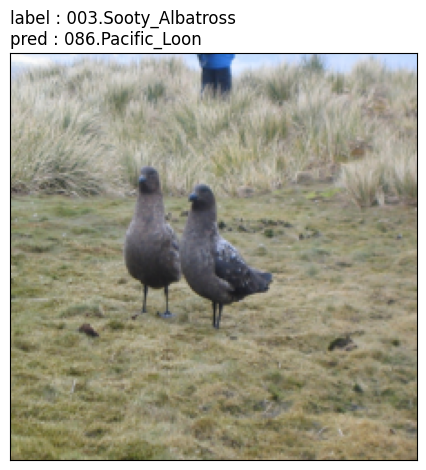

In [8]:
img = image[0].cpu().numpy()
img = np.transpose(img, (1, 2, 0))

# CUBの場合・CIFAR10は適宜変更
mean = np.array([0.4817, 0.4974, 0.4319])
std = np.array([0.2297, 0.2256, 0.2655])

# 逆正規化
img = std * img + mean

# 画像を可視化
plt.imshow(img)
plt.title(f"label : {idx_to_class[label]}\npred : {idx_to_class[prediction_label]}", loc='left')  # 取得したラベル名をタイトルとして表示
plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False, bottom=False, left=False, right=False, top=False)
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "prediction_image.pdf"))
plt.savefig(os.path.join(save_dir, "prediction_image.png"))
plt.show()

#### Attentionの可視化

In [9]:
batch = 0
attentions_lsit = []
for layer in range(0, len(attentions)):
    attentions_lsit.append(attentions[layer][batch].to(torch.float).cpu().detach().numpy())

print("np.shape(attentions_lsit) : ", np.shape(attentions_lsit)) #(layer, head, tokens, tokens)

np.shape(attentions_lsit) :  (12, 6, 197, 197)


##### Attention Rolloutでの可視化

In [10]:
attention_rollout = Attention_Rollout(attentions_lsit)

print("np.shape(attention_rollout) : ", np.shape(attention_rollout)) #(tokens, tokens)

np.shape(attention_rollout) :  (197, 197)


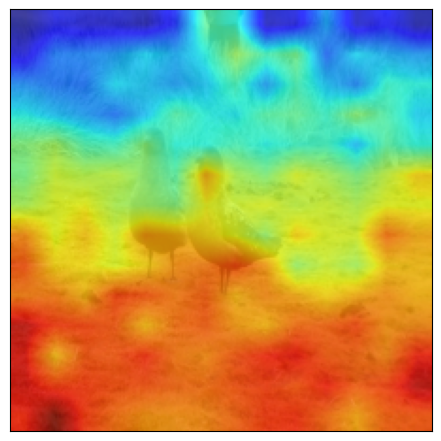

In [11]:
attention_map = cv2.resize(np.reshape(attention_rollout[0][1:], (14,14)), (224, 224), interpolation=cv2.INTER_LINEAR)
attention_map_rgb = heatmap_to_rgb(attention_map)
attention_map = cv2.addWeighted((img* 255).astype(np.uint8), 0.25, attention_map_rgb, 0.75, 0)

plt.imshow(attention_map)
plt.tight_layout()
plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False, bottom=False, left=False, right=False, top=False)
plt.savefig(os.path.join(save_dir, "attention_rollout_map.pdf"), transparent=True)
plt.savefig(os.path.join(save_dir, "attention_rollout_map.png"), transparent=True)
plt.show()


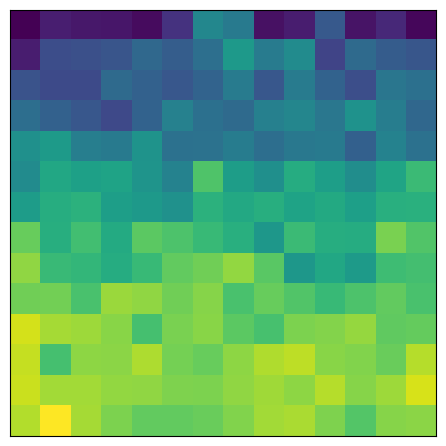

In [12]:
plt.imshow(attention_rollout[0][1:].reshape(14,14))
plt.tight_layout()
plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False, bottom=False, left=False, right=False, top=False)
#plt.savefig(os.path.join(save_dir, "attention_rollout_patch.pdf"), transparent=True)
#plt.savefig(os.path.join(save_dir, "attention_rollout_patch.png"), transparent=True)
plt.show()

#### Sigmoid Attentionの可視化

In [13]:
sigmoid_att = torch.sigmoid(attentions[-1]).cpu().numpy()
print("np.shape(sigmoid_att) : ", np.shape(sigmoid_att))

np.shape(sigmoid_att) :  (1, 6, 197, 197)


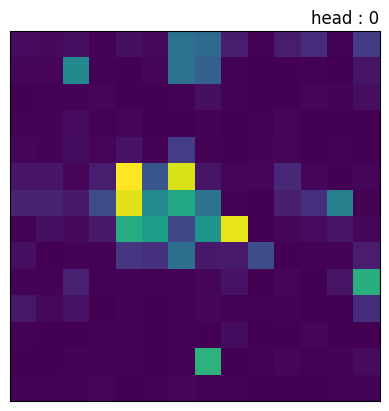

In [14]:
# 0番目のheadを可視化
batch=0
head=0
plt.imshow(np.reshape(sigmoid_att[0][head][0][1:],(14,14)))
plt.title(f"head : {head}", loc="right")
plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False, bottom=False, left=False, right=False, top=False)
plt.show()

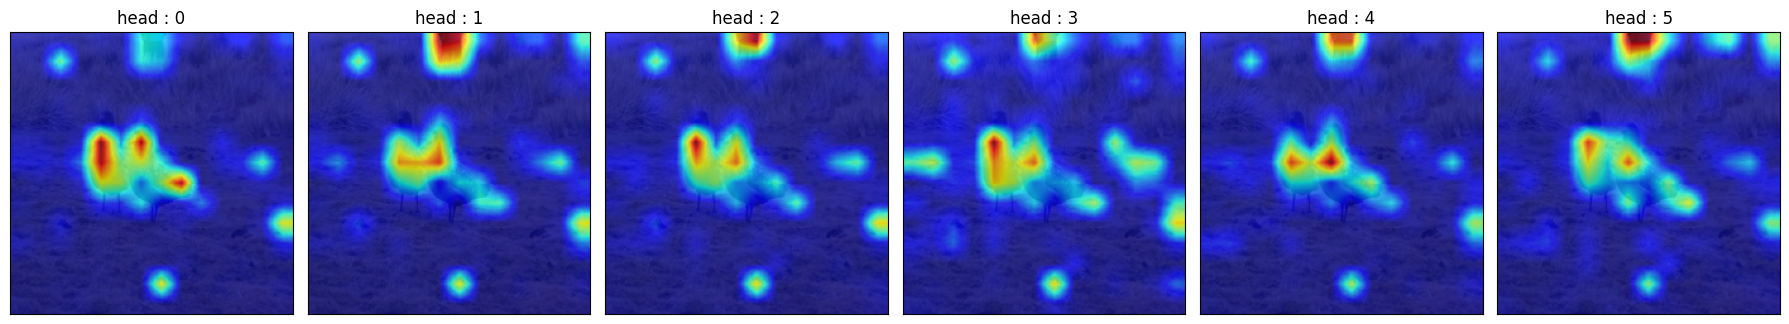

In [15]:
num_heads = np.shape(sigmoid_att)[1]
fig, axes = plt.subplots(1, num_heads, figsize=(18, 5))  # 横並びにするため、1行num_heads列のプロットを作成

for head in range(np.shape(sigmoid_att)[1]):
    attention_map = cv2.resize(np.reshape(sigmoid_att[0][head][0][1:], (14,14)), (224, 224), interpolation=cv2.INTER_LINEAR)
    attention_map_rgb = heatmap_to_rgb(attention_map)
    attention_map = cv2.addWeighted((img* 255).astype(np.uint8), 0.25, attention_map_rgb, 0.75, 0)

    ax = axes[head]  # 各ヘッドに対する軸を取得
    ax.imshow(attention_map)
    ax.set_title(f"head : {head}")
    ax.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False, bottom=False, left=False, right=False, top=False)

plt.tight_layout()
plt.savefig(os.path.join(save_dir, "sigmoid_attention_heads.pdf"), transparent=True)
plt.savefig(os.path.join(save_dir, "sigmoid_attention_heads.png"), transparent=True)
plt.show()
    

In [16]:
sigmoid_att_mean = np.mean(sigmoid_att, axis=1)

In [17]:
sigmoid_att_mean.shape

(1, 197, 197)

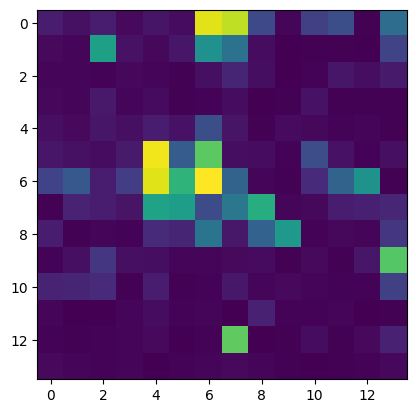

In [18]:
plt.imshow(np.reshape(sigmoid_att_mean[0][0][1:],(14,14)))
#plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False, bottom=False, left=False, right=False, top=False)
#plt.savefig(f'attention/vision_encoder_attn_last_layer.png', transparent=True)
#plt.savefig(f'attention/vision_encoder_attn_last_layer.svg', transparent=True)
plt.show()